In [1]:
import pandas as pd
from functools import partial
import sys

sys.path.append("../Handlers")

JSON_WRITE_MODE = "overwrite"

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
csv_file = pd.read_csv("./SpamAssassin.csv")

csv_file.head()

,Subject,Date,From,To,Received,Content-Type,Body,Is_spam
0,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",['Robert Elz <kre@munnari.OZ.AU>'],['Chris Garrigues <cwg-dated-1030377287.06fa6d...,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",['Steve Burt <Steve_Burt@cursor-system.com>'],"['""\'zzzzteana@yahoogroups.com\'"" <zzzzteana@y...",['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",['Tim Chapman <timc@2ubh.com>'],['zzzzteana <zzzzteana@yahoogroups.com>'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Man Threatens Explosion In Moscow \n\nThursday...,0
3,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",['Monty Solomon <monty@roscom.com>'],['undisclosed-recipient:;'],['from localhost (localhost [127.0.0.1])\tby p...,text/plain,Klez: The Virus That Won't Die\n \nAlready the...,0
4,Re: Insert signature,"Thu, 22 Aug 2002 23:36:32 +1000",['Tony Nugent <tony@linuxworks.com.au>'],['Exmh Users Mailing List <exmh-users@example....,['from localhost (localhost [127.0.0.1])\tby p...,text/plain,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [3]:
preprocession = partial(
    preprocessing.preprocess_text,
    remove_numbers=True
)

preprocessed_data = csv_file["Body"].apply(preprocession)
preprocessed_data

0       [date, DATE, TIME, chris, garrigues, messageid...
1       [martin, posted, tassos, papadopoulos, greek, ...
2       [man, threatens, explosion, moscow, thursday, ...
3       [klez, virus, wont, die, already, prolific, vi...
4       [wed, DATE, TIME, ulises, ponce, wrote, hi, co...
                              ...                        
4193    [preferred, nonsmoker, doctor, ordered, case, ...
4194    [dear, subscriber, could, show, way, get, visi...
4195    [midsummer, customer, appreciation, sale, expr...
4196    [attnsirmadan, strictly, confidential, pleased...
4197    [mv, efaeefcdfdcbaPHONENUMefaeefcdfdcba, mv, e...
Name: Body, Length: 4198, dtype: object

In [ ]:
from traintest import train_and_evaluate_models, add_to_json_array

metric_results = []

## Stemming + CountVectorizer

In [16]:
spam_assassin_stemming = preprocessed_data.apply(preprocessing.stemming)
spam_assassin_stemming_countvec = preprocessing.vectorizing(spam_assassin_stemming, "countvectorizer")

Threading avaiable
Begin SVC
Begin MultinomialNB
Begin BernoulliNB
Multinomial Naive Bayes begins epoch 5
Bernoulli Naive Bayes begins epoch 5
Multinomial Naive Bayes begins epoch 10
Bernoulli Naive Bayes begins epoch 10
MultinomialNB classification report
BernoulliNB classification report


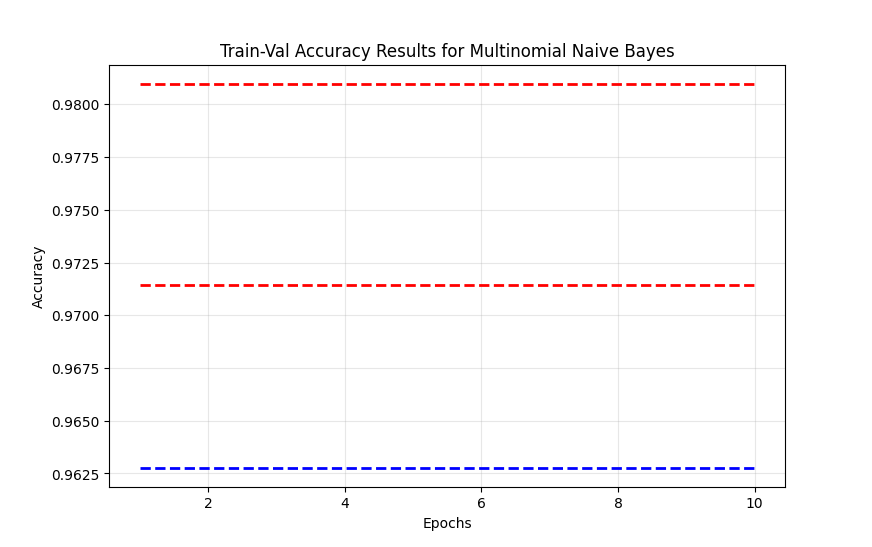

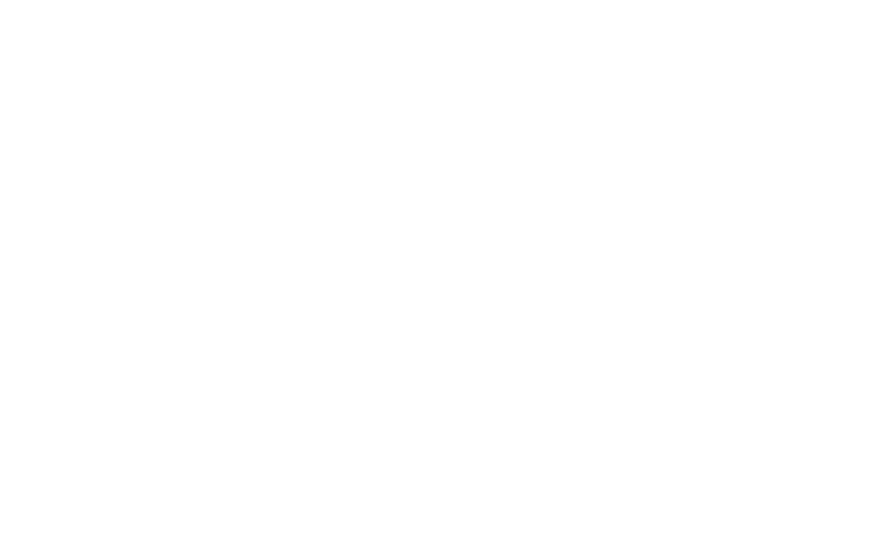

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64), 'epochs': 10}


Begin RandomForestClassifier
{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9572555018970748, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567970448770009, 'macro_precision': 0.9582833852793096, 'macro_recall': 0.9437208222640634, 'macro_f1': 0.9504859710251239, 'roc_auc': 0.9437208222640634}, 'confusion_matrix': array([[278,   5],
       [ 13, 124]], dtype=int64), 'epochs': 10}

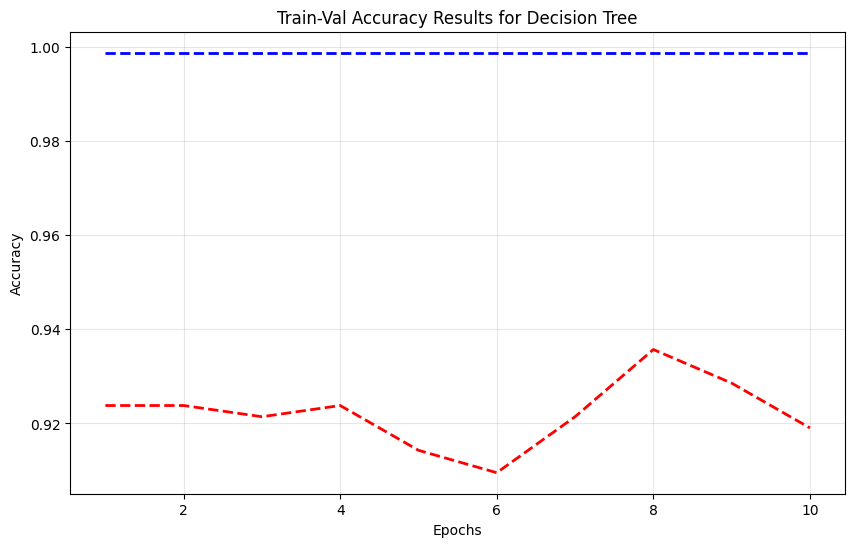

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9261904761904762, 'weighted_precision': 0.9260620093107665, 'wighted_recall': 0.9261904761904762, 'weighted_f1': 0.9261203816759372, 'macro_precision': 0.9166839270919636, 'macro_recall': 0.9151040726316061, 'macro_f1': 0.9158865825532492, 'roc_auc': 0.9151040726316061}, 'confusion_matrix': array([[268,  15],
       [ 16, 121]], dtype=int64), 'epochs': 10}


Begin AdaBoostClassifier
AdaBoost begins epoch 5
Random Forest begins epoch 5
SVM begins epoch 5
AdaBoost begins epoch 10
AdaBoostClassifier classification report


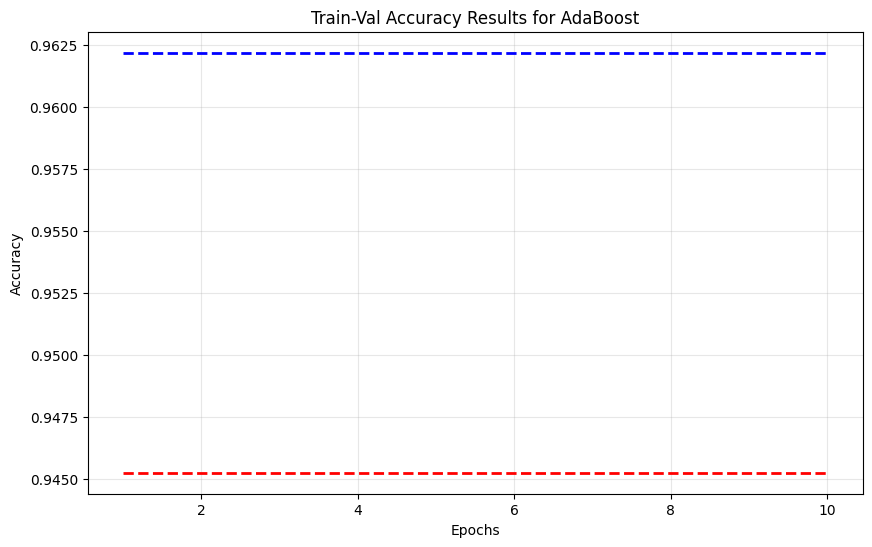

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9428571428571428, 'weighted_precision': 0.9426171546301503, 'wighted_recall': 0.9428571428571428, 'weighted_f1': 0.9425171843082291, 'macro_precision': 0.9396972978684064, 'macro_recall': 0.9293544143818834, 'macro_f1': 0.934244859617994, 'roc_auc': 0.9293544143818833}, 'confusion_matrix': array([[274,   9],
       [ 15, 122]], dtype=int64), 'epochs': 10}


Begin LogisticRegression
Logistic Regression begins epoch 5
Random Forest begins epoch 10
Logistic Regression begins epoch 10
LogisticRegression classification report


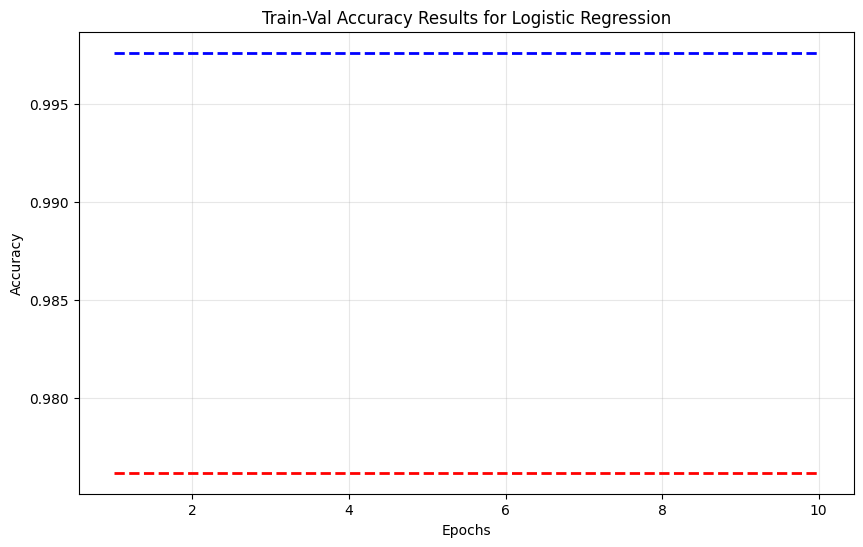

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9857105727281167, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856869156113148, 'macro_precision': 0.9855750487329434, 'macro_recall': 0.981867890949421, 'macro_f1': 0.9836888980944489, 'roc_auc': 0.981867890949421}, 'confusion_matrix': array([[281,   2],
       [  4, 133]], dtype=int64), 'epochs': 10}


Begin KNeighborsClassifier
RandomForestClassifier classification report


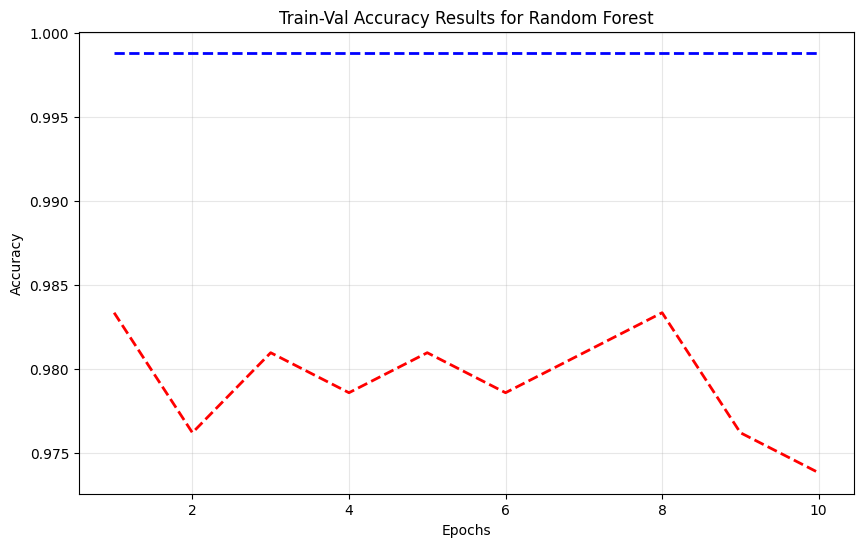

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9809523809523809, 'weighted_precision': 0.9809301030353662, 'wighted_recall': 0.9809523809523809, 'weighted_f1': 0.9809158874817532, 'macro_precision': 0.9801169590643275, 'macro_recall': 0.9764514714606278, 'macro_f1': 0.9782518641259321, 'roc_auc': 0.9764514714606279}, 'confusion_matrix': array([[280,   3],
       [  5, 132]], dtype=int64), 'epochs': 10}


Begin SGDClassifier
Stochastic Gradient Descent begins epoch 5
Stochastic Gradient Descent begins epoch 10
SGDClassifier classification report


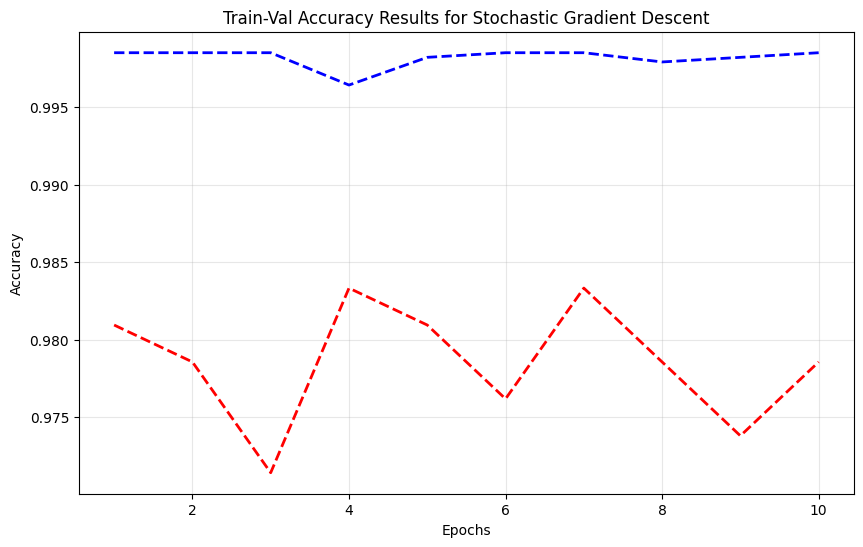

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9619047619047619, 'weighted_precision': 0.9620944627114779, 'wighted_recall': 0.9619047619047619, 'weighted_f1': 0.9619752433813489, 'macro_precision': 0.9551703832663406, 'macro_recall': 0.9585514946738541, 'macro_f1': 0.9568300955905026, 'roc_auc': 0.9585514946738541}, 'confusion_matrix': array([[274,   9],
       [  7, 130]], dtype=int64), 'epochs': 10}


Begin Perceptron
Perceptron begins epoch 5
Perceptron begins epoch 10
Perceptron classification report


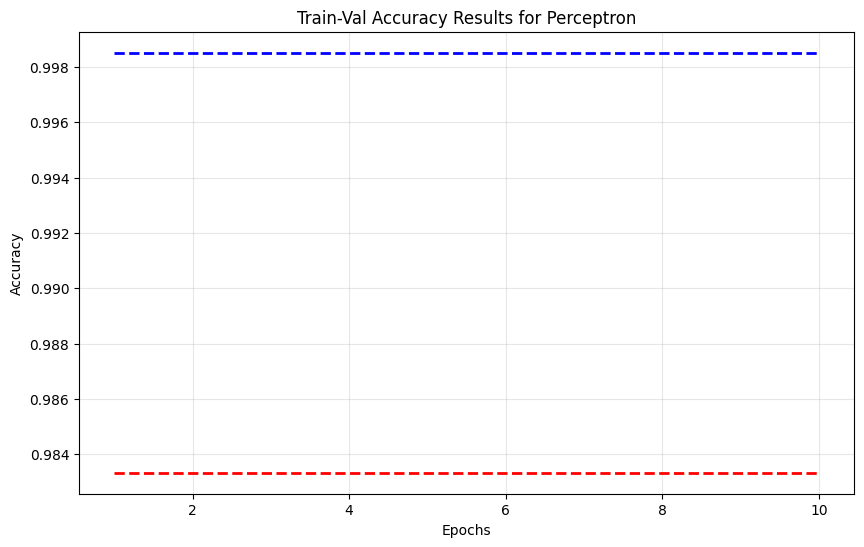

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9714285714285714, 'weighted_precision': 0.9715836481805912, 'wighted_recall': 0.9714285714285714, 'weighted_f1': 0.9714814325360117, 'macro_precision': 0.9659233467318671, 'macro_recall': 0.9693843336514405, 'macro_f1': 0.967622571692877, 'roc_auc': 0.9693843336514406}, 'confusion_matrix': array([[276,   7],
       [  5, 132]], dtype=int64), 'epochs': 10}


Begin PassiveAggressiveClassifier
K-nearest Neighbors begins epoch 5
Passive-Aggressive begins epoch 5
Passive-Aggressive begins epoch 10
PassiveAggressiveClassifier classification report


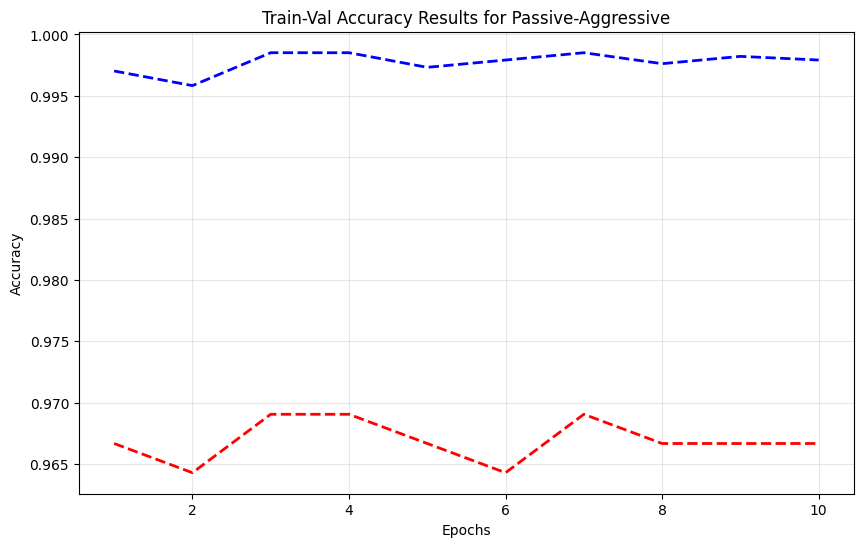

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9642857142857143, 'weighted_precision': 0.9643646388558507, 'wighted_recall': 0.9642857142857143, 'weighted_f1': 0.9643190437880703, 'macro_precision': 0.9586031452358927, 'macro_recall': 0.960318279126151, 'macro_f1': 0.9594529364440869, 'roc_auc': 0.960318279126151}, 'confusion_matrix': array([[275,   8],
       [  7, 130]], dtype=int64), 'epochs': 10}


Begin MLPClassifier
K-nearest Neighbors begins epoch 10
KNeighborsClassifier classification report


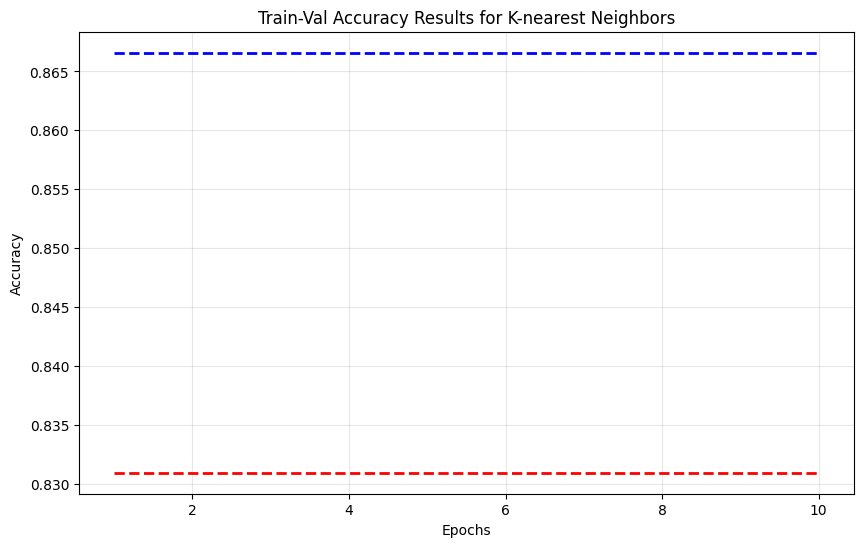

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.8214285714285714, 'weighted_precision': 0.8715093494932716, 'wighted_recall': 0.8214285714285714, 'weighted_f1': 0.8269642762515423, 'macro_precision': 0.8152647833590698, 'macro_recall': 0.858076913156741, 'macro_f1': 0.8145302315722538, 'roc_auc': 0.858076913156741}, 'confusion_matrix': array([[213,  70],
       [  5, 132]], dtype=int64), 'epochs': 10}


SVM begins epoch 10
SVC classification report


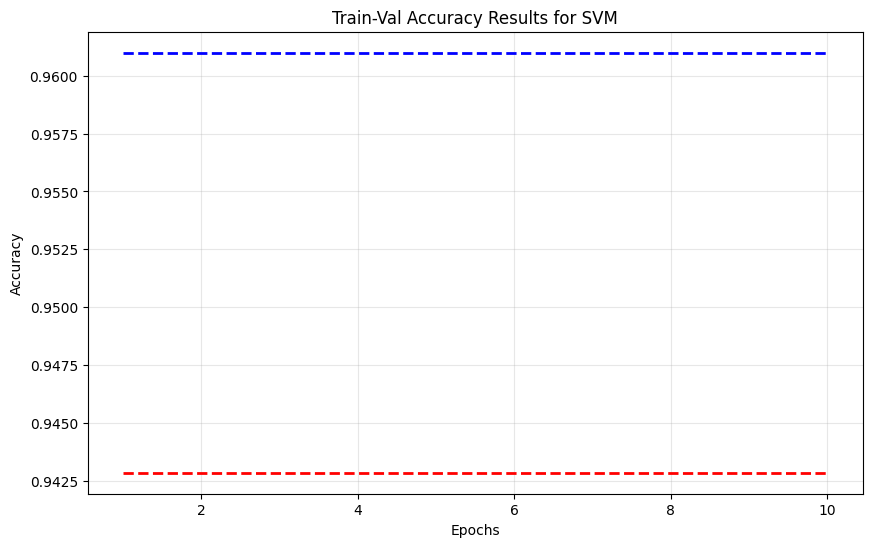

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9285714285714286, 'weighted_precision': 0.9330655204441611, 'wighted_recall': 0.9285714285714286, 'weighted_f1': 0.926395721758625, 'macro_precision': 0.9456835476252952, 'macro_recall': 0.8942766500735085, 'macro_f1': 0.9141782911944202, 'roc_auc': 0.8942766500735085}, 'confusion_matrix': array([[281,   2],
       [ 28, 109]], dtype=int64), 'epochs': 10}


Multi-layer Perceptron begins epoch 5
Multi-layer Perceptron begins epoch 10
MLPClassifier classification report


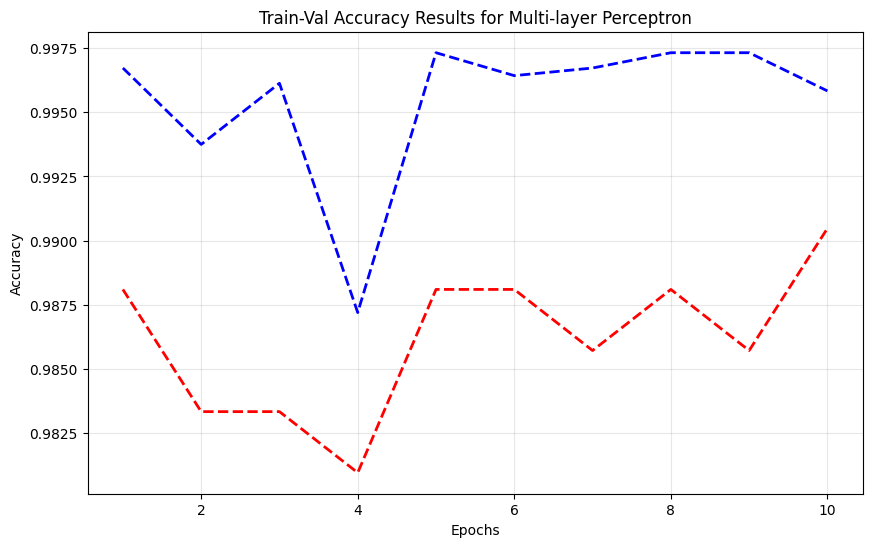

{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9904761904761905, 'weighted_precision': 0.9904761904761905, 'wighted_recall': 0.9904761904761905, 'weighted_f1': 0.9904761904761905, 'macro_precision': 0.9891671610224136, 'macro_recall': 0.9891671610224136, 'macro_f1': 0.9891671610224136, 'roc_auc': 0.9891671610224136}, 'confusion_matrix': array([[281,   2],
       [  2, 135]], dtype=int64), 'epochs': 10}




In [17]:
%reload_ext autoreload
%autoreload 2

train_and_evaluate_models(
    spam_assassin_stemming_countvec, 
    csv_file["Is_spam"],
    "spam_assassin_stemming_countvec",
    metric_results,
    mode="epochs",
    test_size=0.1,
    valid_size=0.1
)

del spam_assassin_stemming_countvec

## Stemming + TF-IDF Vectorizer

In [18]:
spam_assassin_stemming_tfidf = preprocessing.vectorizing(spam_assassin_stemming, "tfidf")
del spam_assassin_stemming

Threading avaiable
Begin SVC
Begin MultinomialNB
Begin BernoulliNB
Multinomial Naive Bayes begins epoch 5
Bernoulli Naive Bayes begins epoch 5
Multinomial Naive Bayes begins epoch 10
MultinomialNB classification report


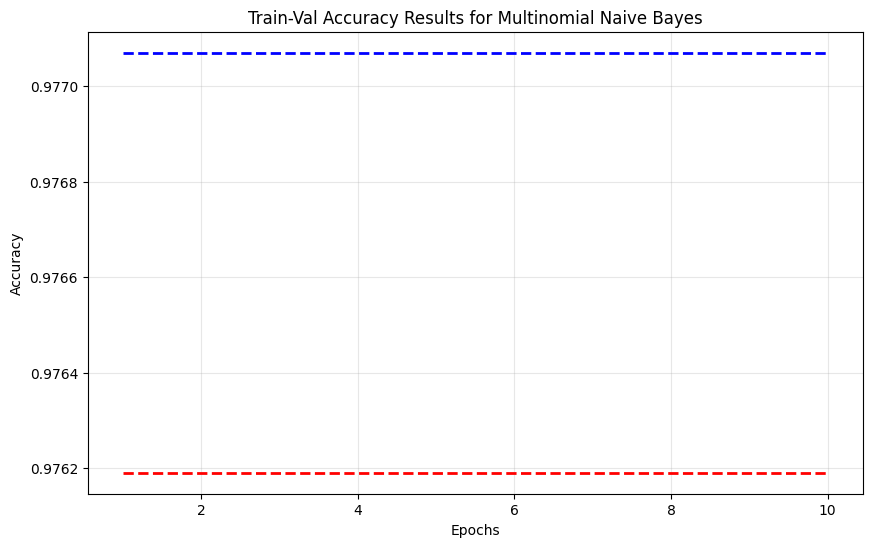

Bernoulli Naive Bayes begins epoch 10
{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9575306073088985, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567031926406926, 'macro_precision': 0.9603611835210017, 'macro_recall': 0.9418379716798638, 'macro_f1': 0.9502840909090908, 'roc_auc': 0.9418379716798638}, 'confusion_matrix': array([[279,   4],
       [ 14, 123]], dtype=int64), 'epochs': 10}


Begin RandomForestClassifier
BernoulliNB classification report


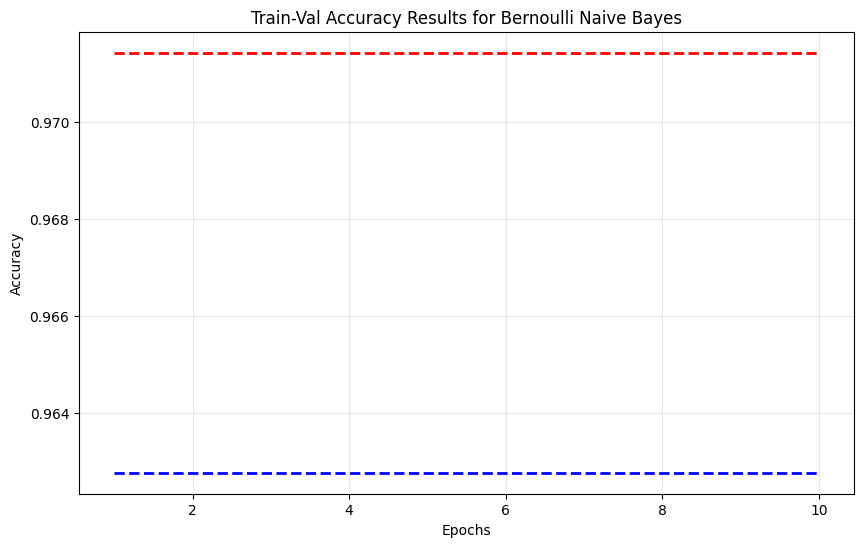

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64), 'epochs': 10}


Begin DecisionTreeClassifier
Decision Tree begins epoch 5
Decision Tree begins epoch 10
DecisionTreeClassifier classification report


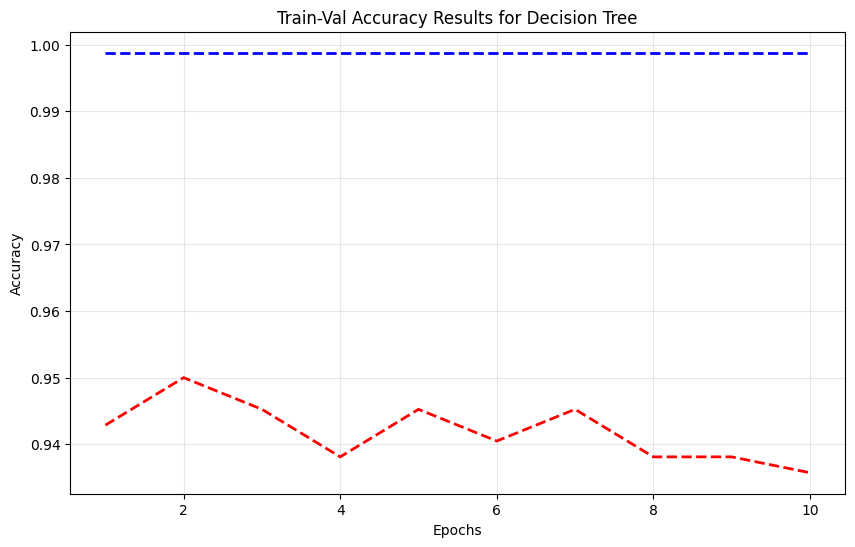

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9261904761904762, 'weighted_precision': 0.9260620093107665, 'wighted_recall': 0.9261904761904762, 'weighted_f1': 0.9261203816759372, 'macro_precision': 0.9166839270919636, 'macro_recall': 0.9151040726316061, 'macro_f1': 0.9158865825532492, 'roc_auc': 0.9151040726316061}, 'confusion_matrix': array([[268,  15],
       [ 16, 121]], dtype=int64), 'epochs': 10}


Begin AdaBoostClassifier
Random Forest begins epoch 5
AdaBoost begins epoch 5
SVM begins epoch 5
Random Forest begins epoch 10
RandomForestClassifier classification report


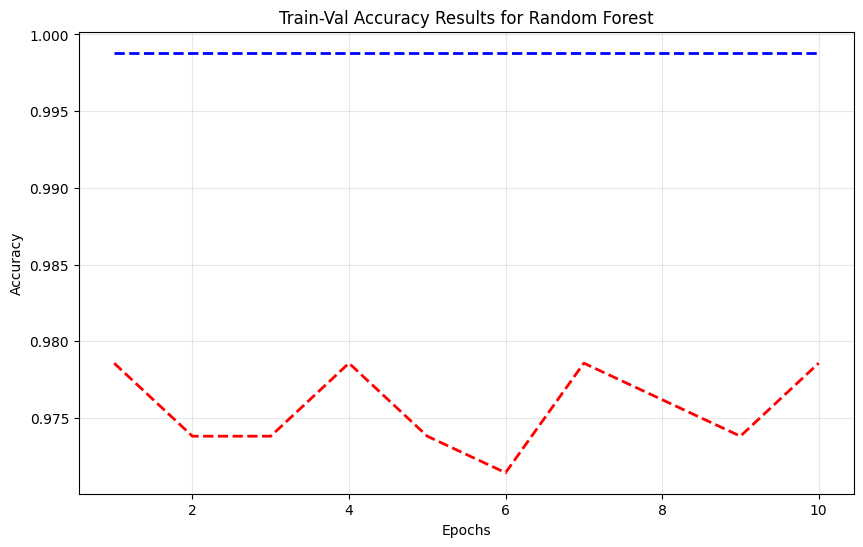

AdaBoost begins epoch 10
{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9904761904761905, 'weighted_precision': 0.9904910424208669, 'wighted_recall': 0.9904761904761905, 'weighted_f1': 0.9904579437408767, 'macro_precision': 0.9910331384015594, 'macro_recall': 0.9872843104382141, 'macro_f1': 0.9891259320629661, 'roc_auc': 0.9872843104382141}, 'confusion_matrix': array([[282,   1],
       [  3, 134]], dtype=int64), 'epochs': 10}


Begin LogisticRegression
Logistic Regression begins epoch 5
AdaBoostClassifier classification report


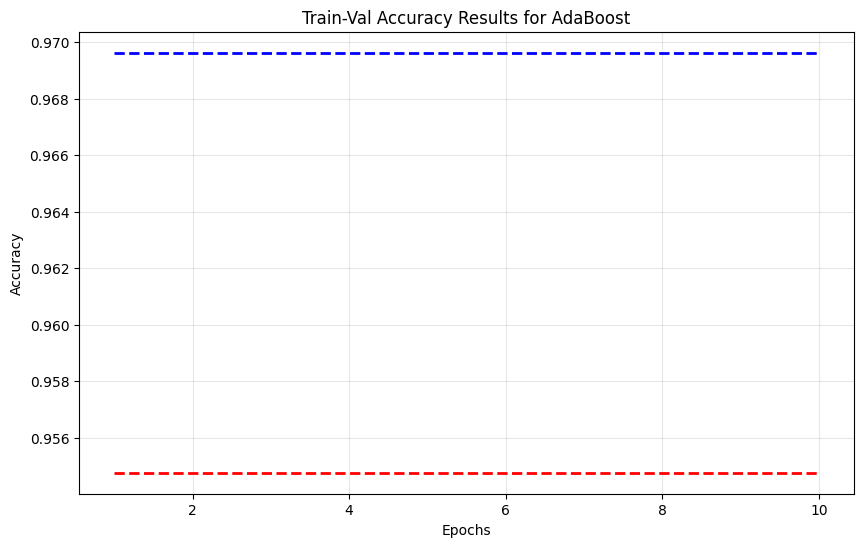

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9476190476190476, 'weighted_precision': 0.9474059713744291, 'wighted_recall': 0.9476190476190476, 'weighted_f1': 0.9474148333797456, 'macro_precision': 0.9435173299101411, 'macro_recall': 0.9366536844548761, 'macro_f1': 0.9399610136452241, 'roc_auc': 0.9366536844548761}, 'confusion_matrix': array([[274,   9],
       [ 13, 124]], dtype=int64), 'epochs': 10}


Begin KNeighborsClassifier
Logistic Regression begins epoch 10
LogisticRegression classification report


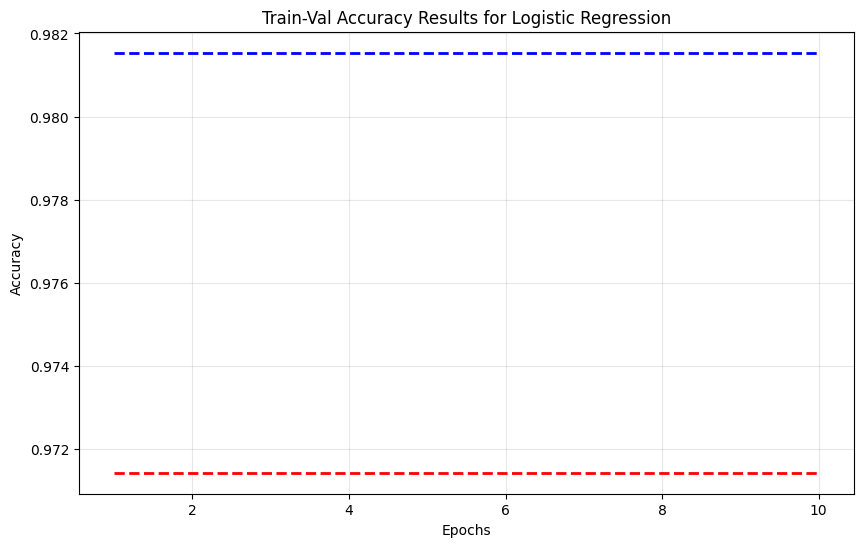

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9568531746031746, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9539252637336479, 'macro_precision': 0.9658333333333333, 'macro_recall': 0.9325397848907688, 'macro_f1': 0.946739993726265, 'roc_auc': 0.9325397848907688}, 'confusion_matrix': array([[282,   1],
       [ 18, 119]], dtype=int64), 'epochs': 10}


Begin SGDClassifier
Stochastic Gradient Descent begins epoch 5
Stochastic Gradient Descent begins epoch 10
SGDClassifier classification report


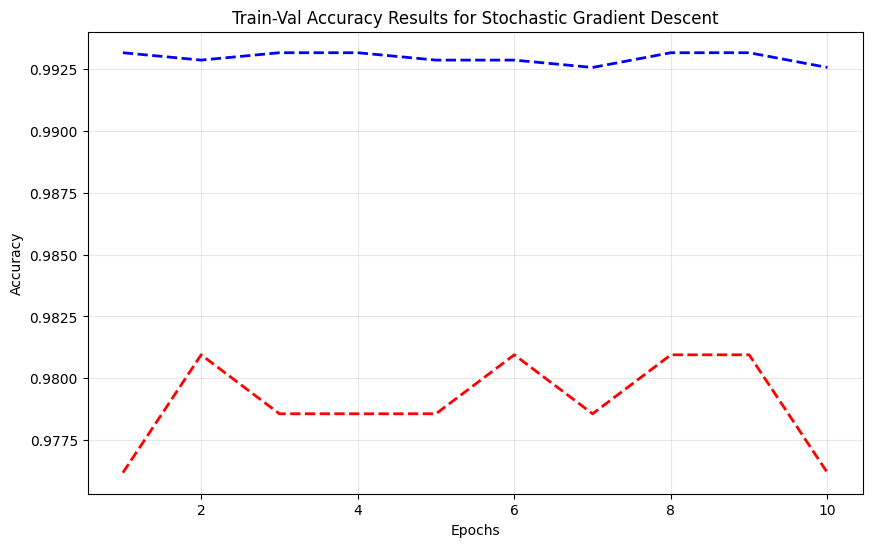

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9666666666666667, 'weighted_precision': 0.9672668476167441, 'wighted_recall': 0.9666666666666667, 'weighted_f1': 0.9663247053872055, 'macro_precision': 0.9716481685523097, 'macro_recall': 0.9526708106574502, 'macro_f1': 0.9613320707070707, 'roc_auc': 0.9526708106574502}, 'confusion_matrix': array([[281,   2],
       [ 12, 125]], dtype=int64), 'epochs': 10}


Begin Perceptron
Perceptron begins epoch 5
Perceptron begins epoch 10
Perceptron classification report


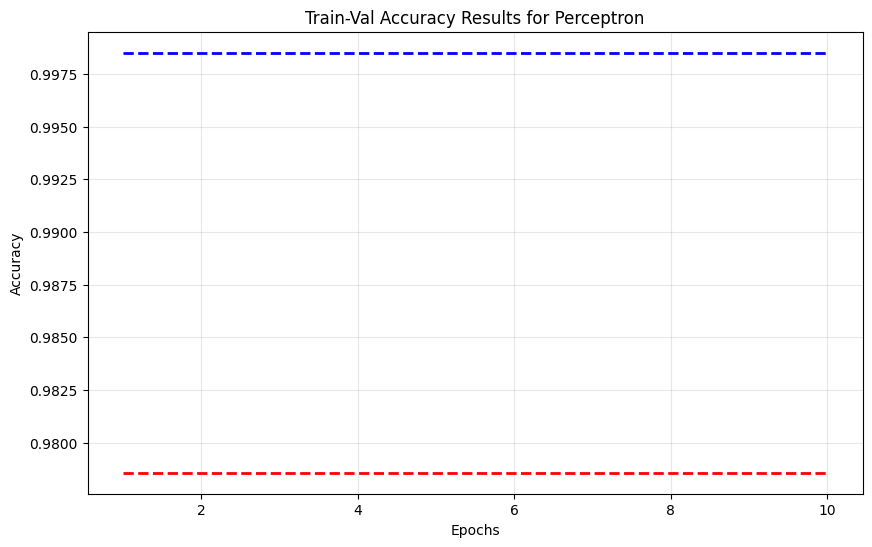

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9761904761904762, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9761904761904762, 'macro_precision': 0.9729179025560342, 'macro_recall': 0.9729179025560342, 'macro_f1': 0.9729179025560342, 'roc_auc': 0.9729179025560343}, 'confusion_matrix': array([[278,   5],
       [  5, 132]], dtype=int64), 'epochs': 10}


Begin PassiveAggressiveClassifier
Passive-Aggressive begins epoch 5
Passive-Aggressive begins epoch 10
PassiveAggressiveClassifier classification report


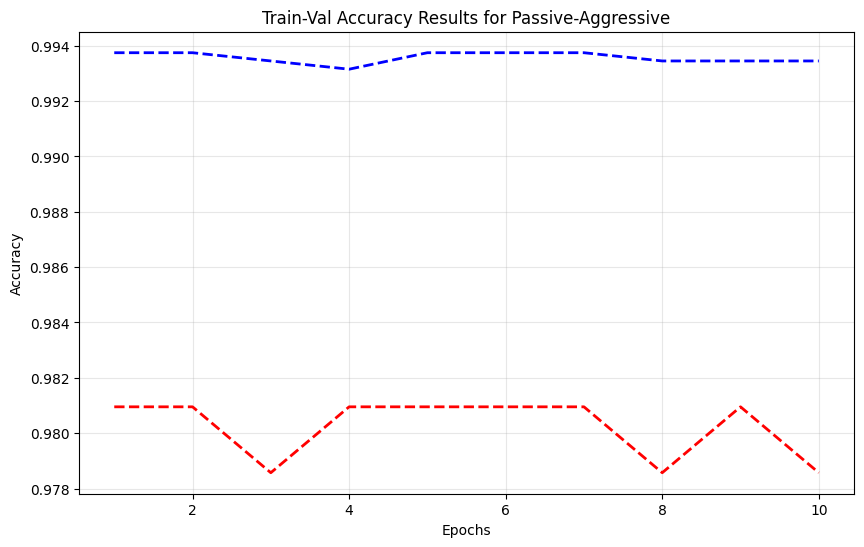

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9666666666666667, 'weighted_precision': 0.9672668476167441, 'wighted_recall': 0.9666666666666667, 'weighted_f1': 0.9663247053872055, 'macro_precision': 0.9716481685523097, 'macro_recall': 0.9526708106574502, 'macro_f1': 0.9613320707070707, 'roc_auc': 0.9526708106574502}, 'confusion_matrix': array([[281,   2],
       [ 12, 125]], dtype=int64), 'epochs': 10}


Begin MLPClassifier
SVM begins epoch 10
K-nearest Neighbors begins epoch 5
SVC classification report


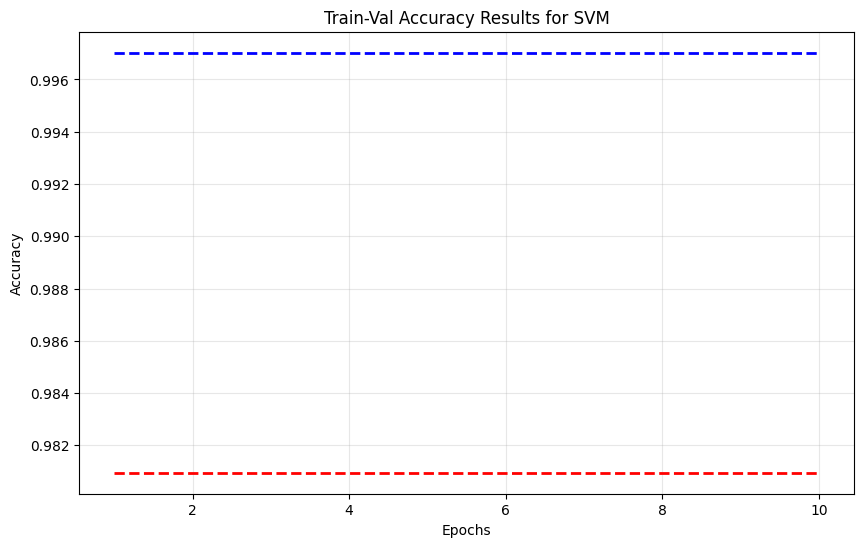

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9747894395853579, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9735114634845113, 'macro_precision': 0.9812925170068028, 'macro_recall': 0.9598540145985401, 'macro_f1': 0.9695553900798017, 'roc_auc': 0.9598540145985401}, 'confusion_matrix': array([[283,   0],
       [ 11, 126]], dtype=int64), 'epochs': 10}


Multi-layer Perceptron begins epoch 5
K-nearest Neighbors begins epoch 10
KNeighborsClassifier classification report


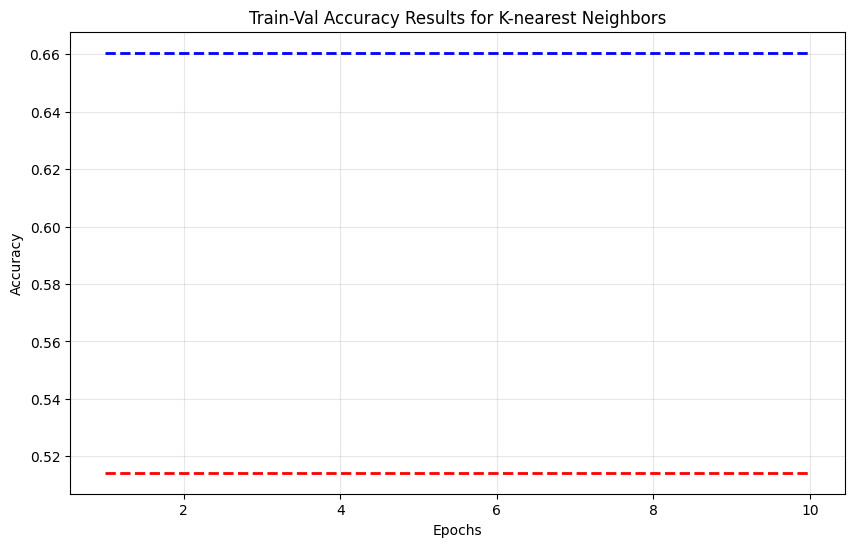

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.5261904761904762, 'weighted_precision': 0.8068098072562359, 'wighted_recall': 0.5261904761904762, 'weighted_f1': 0.4974028717200887, 'macro_precision': 0.7038690476190477, 'macro_recall': 0.6484098939929328, 'macro_f1': 0.5185234257536393, 'roc_auc': 0.6484098939929328}, 'confusion_matrix': array([[ 84, 199],
       [  0, 137]], dtype=int64), 'epochs': 10}


Multi-layer Perceptron begins epoch 10
MLPClassifier classification report


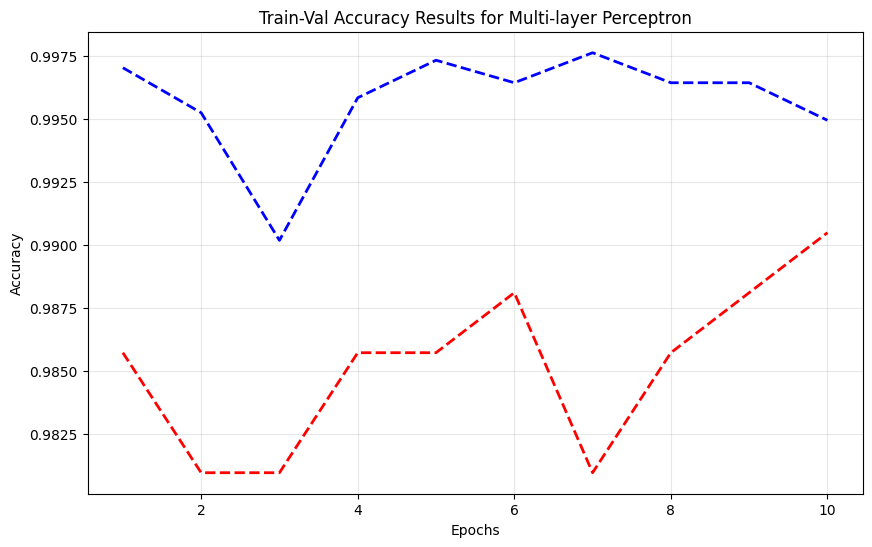

{'dataset': 'spam_assassin_stemmed_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9880952380952381, 'weighted_precision': 0.988141833291087, 'wighted_recall': 0.9880952380952381, 'weighted_f1': 0.9880607279585222, 'macro_precision': 0.989275649723411, 'macro_recall': 0.9836346754017178, 'macro_f1': 0.9863812346383569, 'roc_auc': 0.9836346754017178}, 'confusion_matrix': array([[282,   1],
       [  4, 133]], dtype=int64), 'epochs': 10}




In [19]:
train_and_evaluate_models(
    spam_assassin_stemming_tfidf, 
    csv_file["Is_spam"], 
    "spam_assassin_stemmed_tfidf",
    metric_results,
    mode="epochs",
    test_size=0.1,
    valid_size=0.1
)

del spam_assassin_stemming_tfidf

## Lemmatizing + CountVectorizer

In [23]:
spam_assassin_lemmatizing = preprocessed_data.apply(preprocessing.lemmatizing)
spam_assassin_lemmatizing_countvec = preprocessing.vectorizing(spam_assassin_lemmatizing, "countvectorizer")

Threading avaiable
Begin SVC
Begin MultinomialNB
Begin BernoulliNB
Multinomial Naive Bayes begins epoch 5
Bernoulli Naive Bayes begins epoch 5
Multinomial Naive Bayes begins epoch 10
MultinomialNB classification report


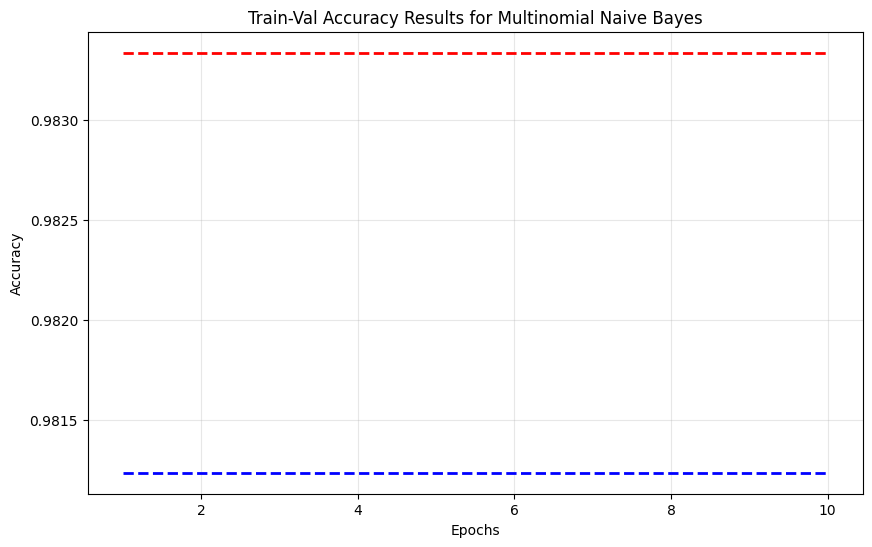

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9595238095238096, 'weighted_precision': 0.9598081784083496, 'wighted_recall': 0.9595238095238096, 'weighted_f1': 0.9591532481737567, 'macro_precision': 0.9621147260273972, 'macro_recall': 0.9454876067163602, 'macro_f1': 0.9531419196062346, 'roc_auc': 0.9454876067163601}, 'confusion_matrix': array([[279,   4],
       [ 13, 124]], dtype=int64), 'epochs': 10}


Begin RandomForestClassifier
Bernoulli Naive Bayes begins epoch 10
BernoulliNB classification report


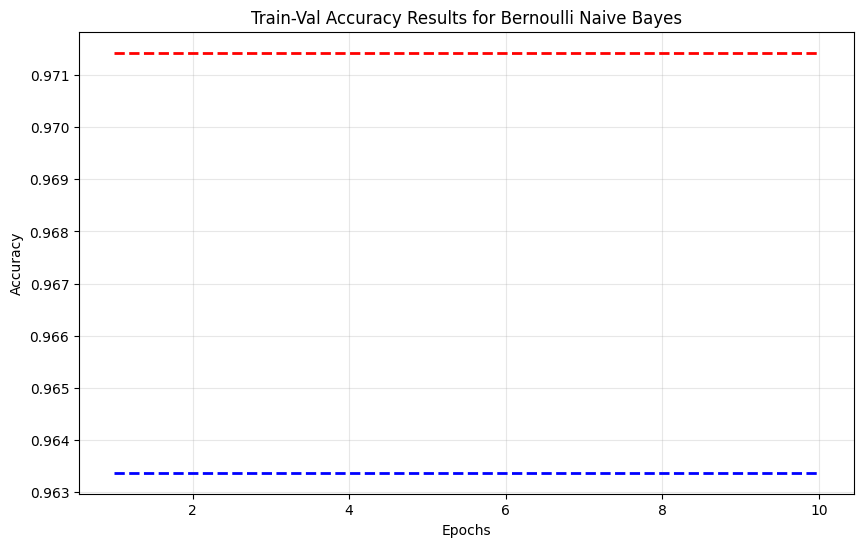

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64), 'epochs': 10}


Begin DecisionTreeClassifier
Decision Tree begins epoch 5
Decision Tree begins epoch 10
DecisionTreeClassifier classification report


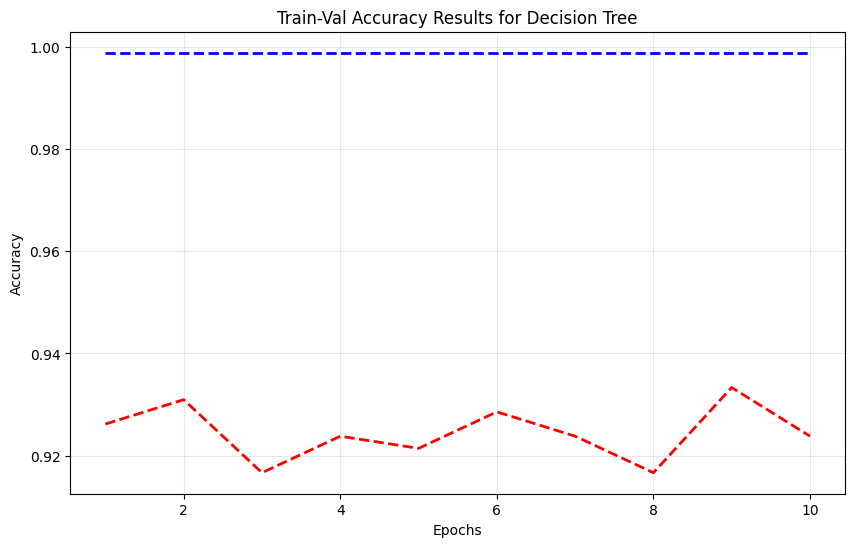

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9476190476190476, 'weighted_precision': 0.9474668151861133, 'wighted_recall': 0.9476190476190476, 'weighted_f1': 0.9475186905748214, 'macro_precision': 0.9419103313840156, 'macro_recall': 0.9385365350390755, 'macro_f1': 0.9401926263463131, 'roc_auc': 0.9385365350390756}, 'confusion_matrix': array([[273,  10],
       [ 12, 125]], dtype=int64), 'epochs': 10}


Begin AdaBoostClassifier
AdaBoost begins epoch 5
Random Forest begins epoch 5
SVM begins epoch 5
AdaBoost begins epoch 10
AdaBoostClassifier classification report


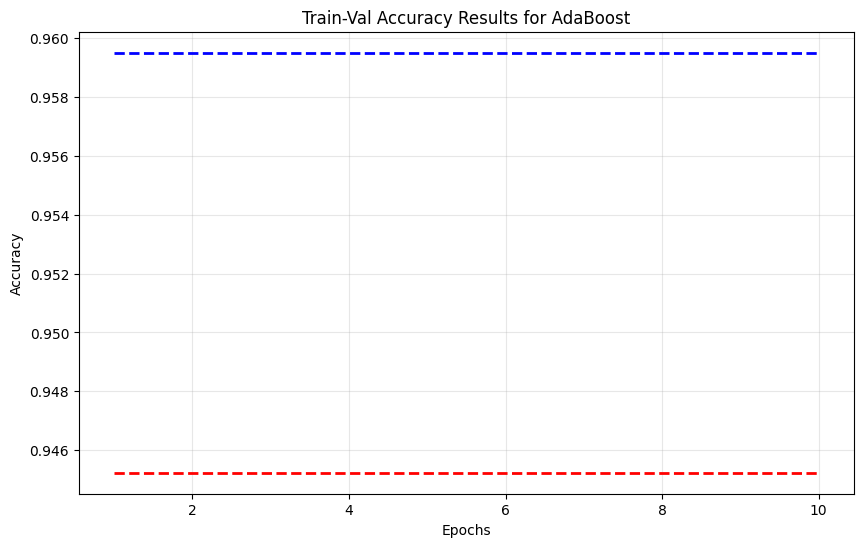

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9403844585779517, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9399312473143482, 'macro_precision': 0.939640410958904, 'macro_recall': 0.9238219287611875, 'macro_f1': 0.9310910582444627, 'roc_auc': 0.9238219287611875}, 'confusion_matrix': array([[275,   8],
       [ 17, 120]], dtype=int64), 'epochs': 10}


Begin LogisticRegression
Logistic Regression begins epoch 5
Random Forest begins epoch 10
Logistic Regression begins epoch 10
LogisticRegression classification report


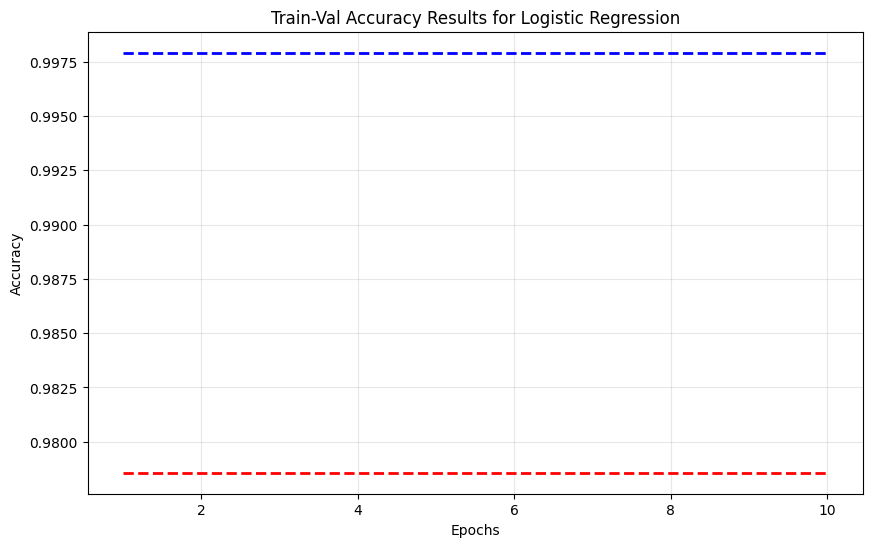

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9857142857142858, 'weighted_precision': 0.9857105727281167, 'wighted_recall': 0.9857142857142858, 'weighted_f1': 0.9856869156113148, 'macro_precision': 0.9855750487329434, 'macro_recall': 0.981867890949421, 'macro_f1': 0.9836888980944489, 'roc_auc': 0.981867890949421}, 'confusion_matrix': array([[281,   2],
       [  4, 133]], dtype=int64), 'epochs': 10}


Begin KNeighborsClassifier
K-nearest Neighbors begins epoch 5
RandomForestClassifier classification report


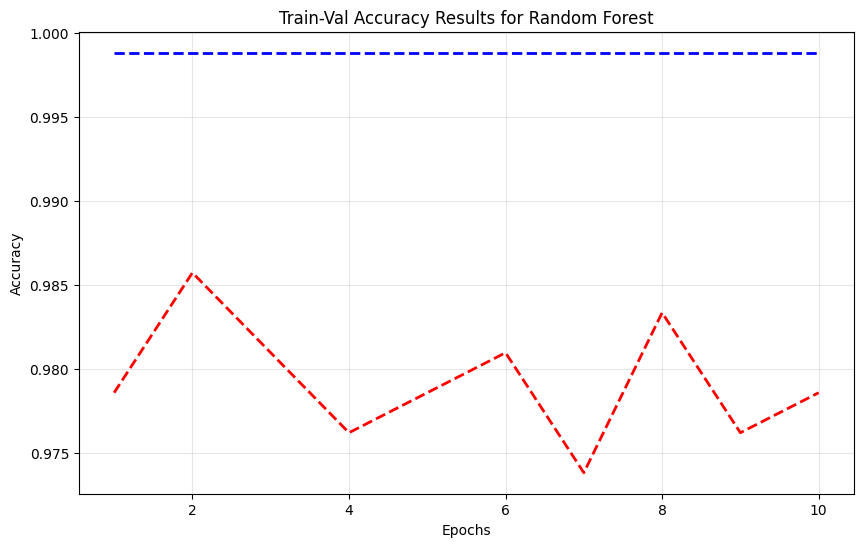

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9763678259808639, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9760488267950956, 'macro_precision': 0.9785255817639135, 'macro_recall': 0.9672693508034356, 'macro_f1': 0.9726020248408308, 'roc_auc': 0.9672693508034356}, 'confusion_matrix': array([[281,   2],
       [  8, 129]], dtype=int64), 'epochs': 10}


Begin SGDClassifier
Stochastic Gradient Descent begins epoch 5
Stochastic Gradient Descent begins epoch 10
SGDClassifier classification report


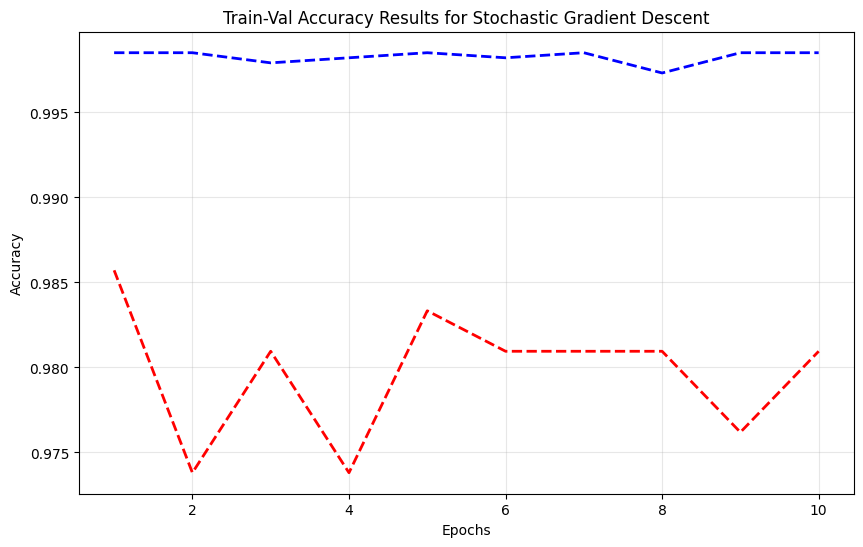

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9833333333333333, 'weighted_precision': 0.9833143468655067, 'wighted_recall': 0.9833333333333333, 'weighted_f1': 0.9833175055397279, 'macro_precision': 0.9819283347141674, 'macro_recall': 0.9801011064971241, 'macro_f1': 0.9810066476733144, 'roc_auc': 0.9801011064971241}, 'confusion_matrix': array([[280,   3],
       [  4, 133]], dtype=int64), 'epochs': 10}


Begin Perceptron
Perceptron begins epoch 5
Perceptron begins epoch 10
Perceptron classification report


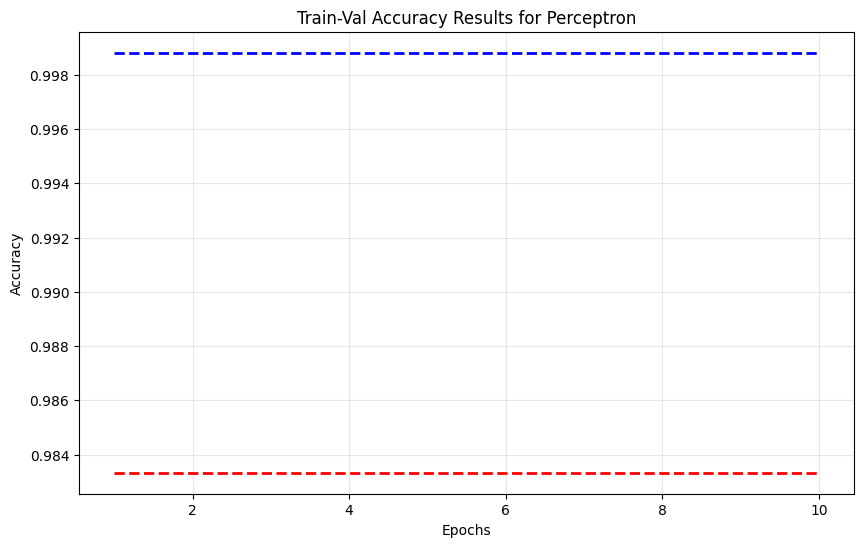

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9738095238095238, 'weighted_precision': 0.9738708280105135, 'wighted_recall': 0.9738095238095238, 'weighted_f1': 0.9738339654445849, 'macro_precision': 0.9693956213382671, 'macro_recall': 0.9711511181037373, 'macro_f1': 0.9702654867256637, 'roc_auc': 0.9711511181037373}, 'confusion_matrix': array([[277,   6],
       [  5, 132]], dtype=int64), 'epochs': 10}


Begin PassiveAggressiveClassifier
Passive-Aggressive begins epoch 5
Passive-Aggressive begins epoch 10
PassiveAggressiveClassifier classification report


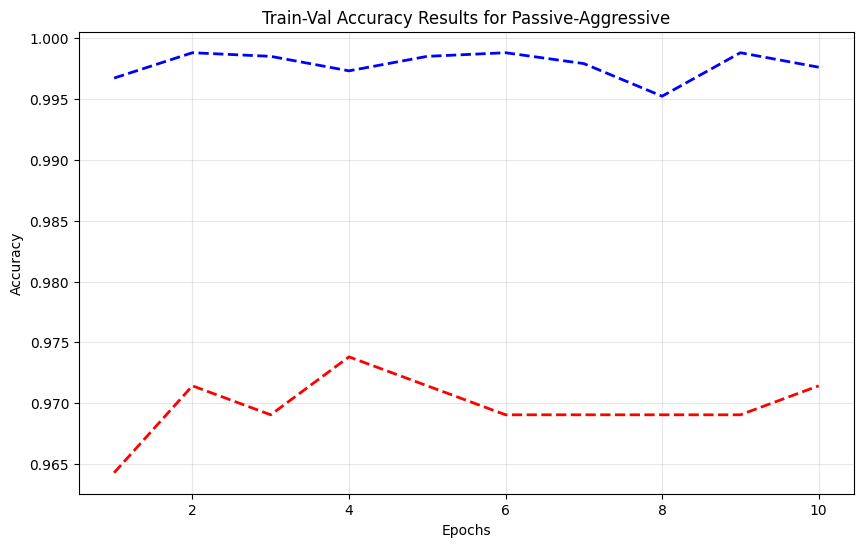

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9666666666666667, 'weighted_precision': 0.9666072847624289, 'wighted_recall': 0.9666666666666667, 'weighted_f1': 0.9665367121507472, 'macro_precision': 0.9655235650100862, 'macro_recall': 0.9583193624100488, 'macro_f1': 0.9617933723196881, 'roc_auc': 0.9583193624100488}, 'confusion_matrix': array([[278,   5],
       [  9, 128]], dtype=int64), 'epochs': 10}


Begin MLPClassifier
K-nearest Neighbors begins epoch 10
KNeighborsClassifier classification report


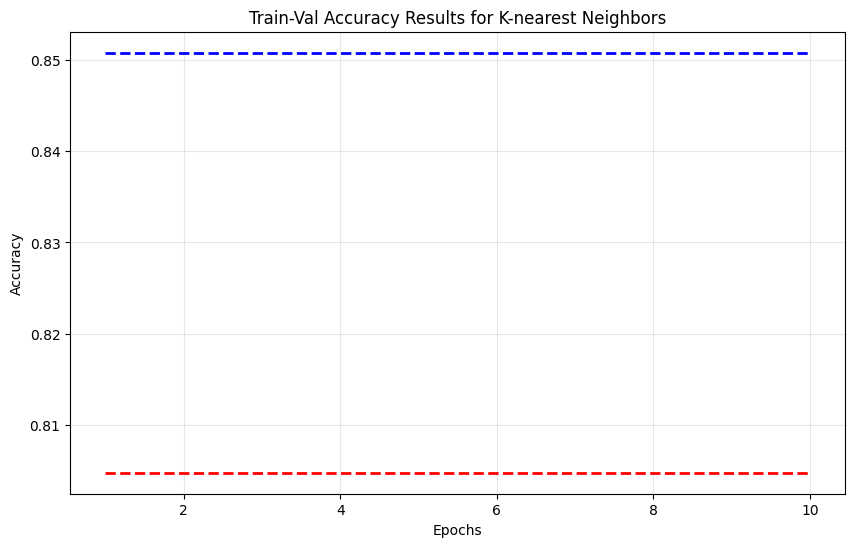

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.8, 'weighted_precision': 0.8672490073737947, 'wighted_recall': 0.8, 'weighted_f1': 0.8061754843517139, 'macro_precision': 0.8043108338060125, 'macro_recall': 0.8459415542544686, 'macro_f1': 0.7946162444113264, 'roc_auc': 0.8459415542544685}, 'confusion_matrix': array([[202,  81],
       [  3, 134]], dtype=int64), 'epochs': 10}


SVM begins epoch 10
SVC classification report


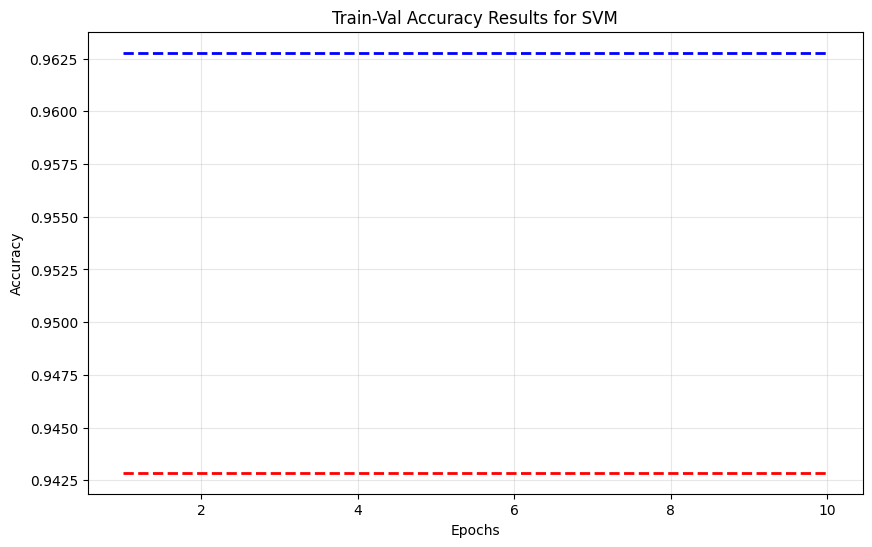

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9261904761904762, 'weighted_precision': 0.9321903405236739, 'wighted_recall': 0.9261904761904762, 'weighted_f1': 0.9236208769221974, 'macro_precision': 0.9472934472934473, 'macro_recall': 0.8887441644528127, 'macro_f1': 0.9106842737094838, 'roc_auc': 0.8887441644528127}, 'confusion_matrix': array([[282,   1],
       [ 30, 107]], dtype=int64), 'epochs': 10}


Multi-layer Perceptron begins epoch 5
Multi-layer Perceptron begins epoch 10
MLPClassifier classification report


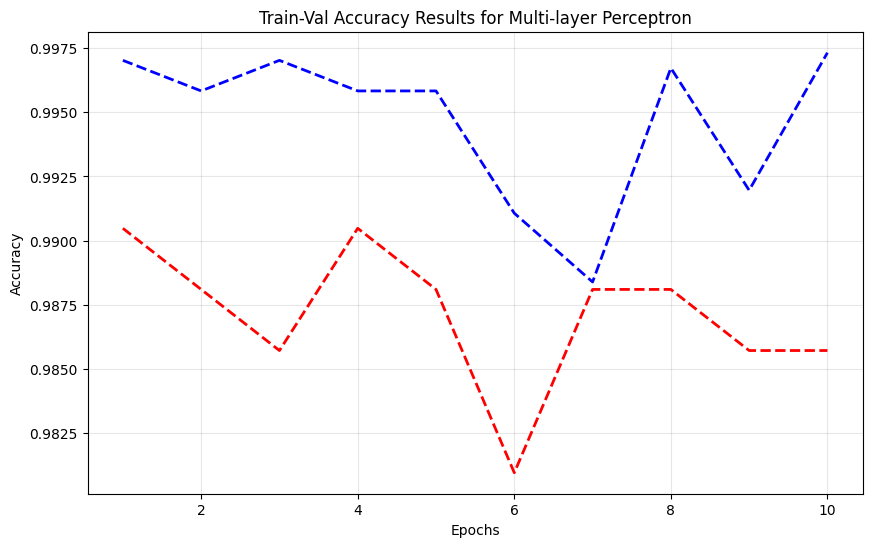

{'dataset': 'spam_assassin_lemmatized_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9904761904761905, 'weighted_precision': 0.9904910424208669, 'wighted_recall': 0.9904761904761905, 'weighted_f1': 0.9904579437408767, 'macro_precision': 0.9910331384015594, 'macro_recall': 0.9872843104382141, 'macro_f1': 0.9891259320629661, 'roc_auc': 0.9872843104382141}, 'confusion_matrix': array([[282,   1],
       [  3, 134]], dtype=int64), 'epochs': 10}




In [21]:
train_and_evaluate_models(
    spam_assassin_lemmatizing_countvec, 
    csv_file["Is_spam"], 
    "spam_assassin_lemmatized_countvec",
    metric_results,
    mode="epochs",
    test_size=0.1,
    valid_size=0.1)

del spam_assassin_lemmatizing_countvec

## Lemmatizing + TF-IDF Vectorizer

In [24]:
spam_assassin_lemmatizing_tfidf = preprocessing.vectorizing(spam_assassin_lemmatizing, "tfidf")

Threading avaiable
Begin SVC
Begin MultinomialNB
Begin BernoulliNB
Multinomial Naive Bayes begins epoch 5
Bernoulli Naive Bayes begins epoch 5
Multinomial Naive Bayes begins epoch 10
MultinomialNB classification report
Bernoulli Naive Bayes begins epoch 10


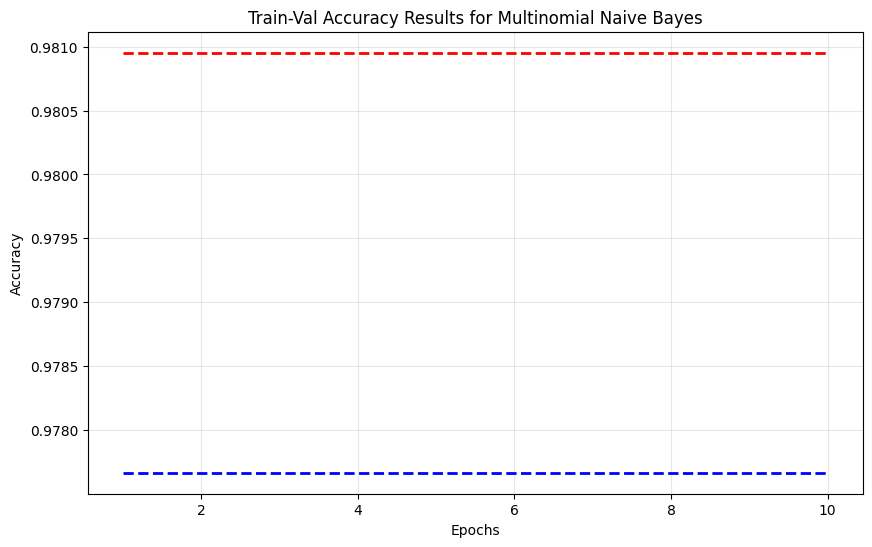

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9556861585087392, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9541431397961682, 'macro_precision': 0.9608761987794245, 'macro_recall': 0.936305486059168, 'macro_f1': 0.9471939332578961, 'roc_auc': 0.936305486059168}, 'confusion_matrix': array([[280,   3],
       [ 16, 121]], dtype=int64), 'epochs': 10}


Begin RandomForestClassifier
BernoulliNB classification report


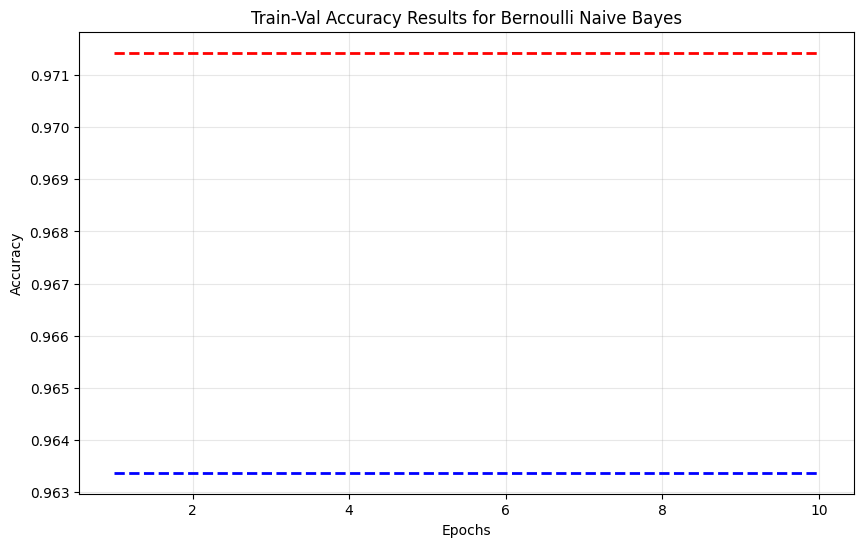

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64), 'epochs': 10}


Begin DecisionTreeClassifier
Decision Tree begins epoch 5
Decision Tree begins epoch 10
DecisionTreeClassifier classification report


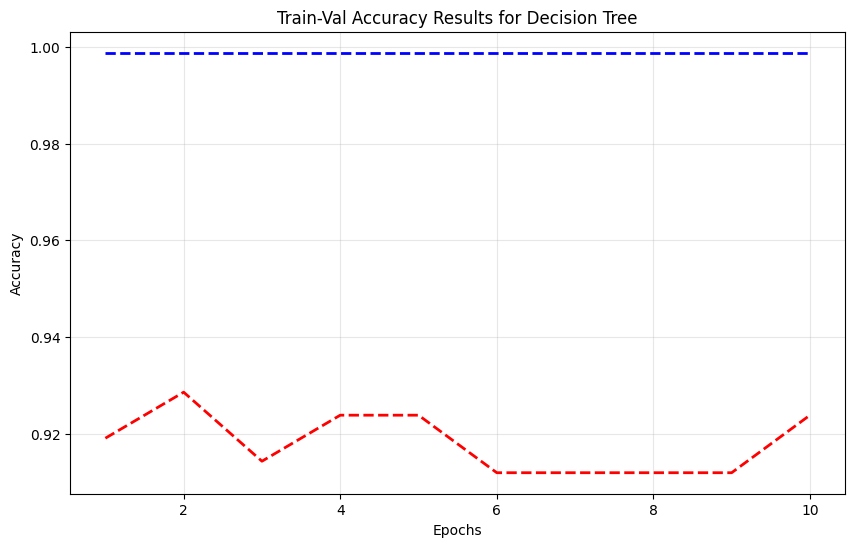

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9428571428571428, 'weighted_precision': 0.9431160917732514, 'wighted_recall': 0.9428571428571428, 'weighted_f1': 0.9429628650720233, 'macro_precision': 0.9336644563352876, 'macro_recall': 0.9368858167186815, 'macro_f1': 0.9352451433857539, 'roc_auc': 0.9368858167186814}, 'confusion_matrix': array([[270,  13],
       [ 11, 126]], dtype=int64), 'epochs': 10}


Begin AdaBoostClassifier
Random Forest begins epoch 5
AdaBoost begins epoch 5
SVM begins epoch 5
Random Forest begins epoch 10
RandomForestClassifier classification report


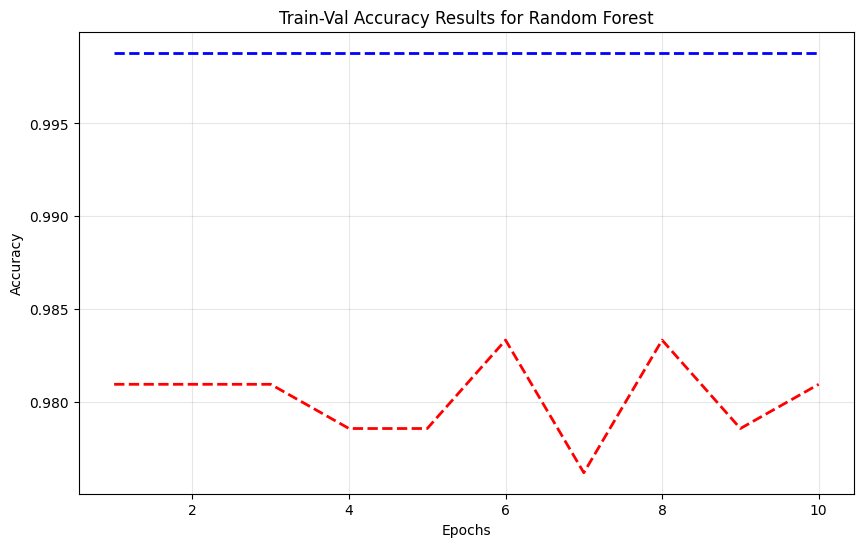

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9880952380952381, 'weighted_precision': 0.9880853749950684, 'wighted_recall': 0.9880952380952381, 'weighted_f1': 0.9880839325283769, 'macro_precision': 0.9873653686826844, 'macro_recall': 0.9855175259859172, 'macro_f1': 0.986433319766653, 'roc_auc': 0.9855175259859172}, 'confusion_matrix': array([[281,   2],
       [  3, 134]], dtype=int64), 'epochs': 10}


Begin LogisticRegression
AdaBoost begins epoch 10
Logistic Regression begins epoch 5
AdaBoostClassifier classification report


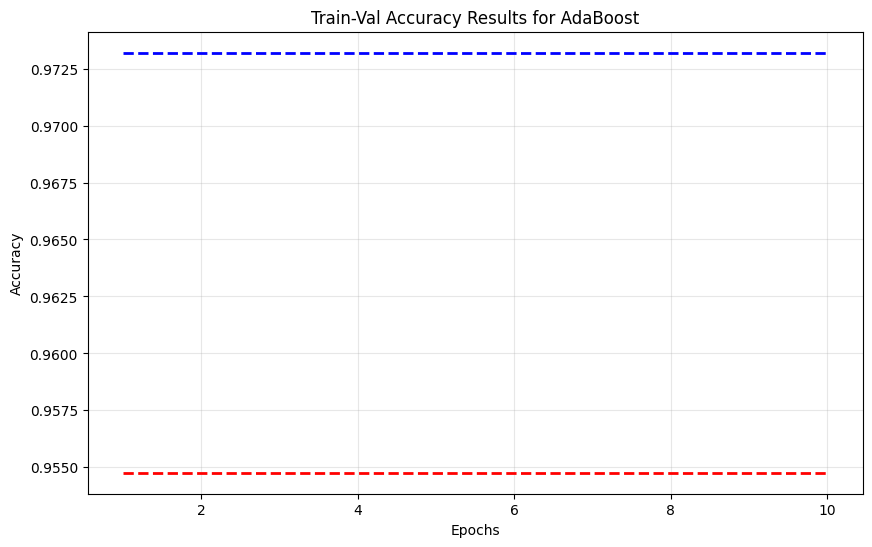

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9405991659691938, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9405317396467839, 'macro_precision': 0.9316219549799569, 'macro_recall': 0.9332361816821851, 'macro_f1': 0.9324215607401448, 'roc_auc': 0.9332361816821853}, 'confusion_matrix': array([[270,  13],
       [ 12, 125]], dtype=int64), 'epochs': 10}


Begin KNeighborsClassifier
Logistic Regression begins epoch 10
LogisticRegression classification report


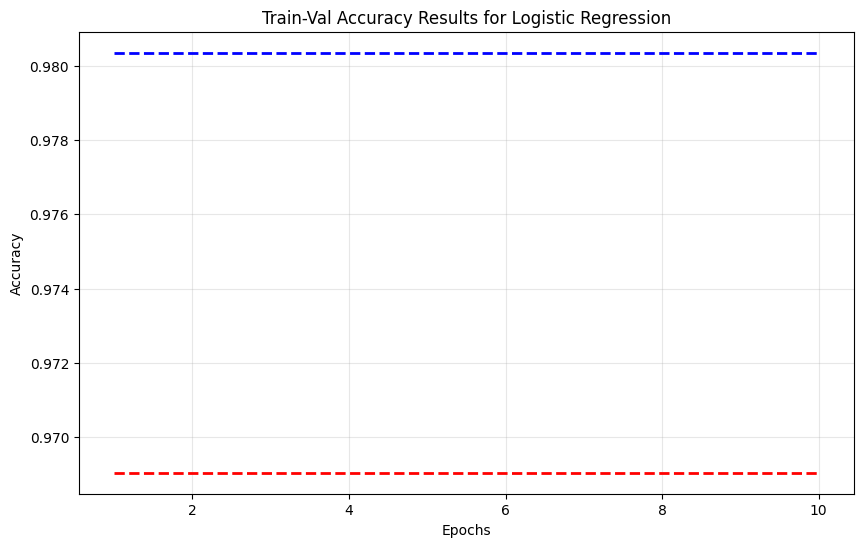

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9547619047619048, 'weighted_precision': 0.9568531746031746, 'wighted_recall': 0.9547619047619048, 'weighted_f1': 0.9539252637336479, 'macro_precision': 0.9658333333333333, 'macro_recall': 0.9325397848907688, 'macro_f1': 0.946739993726265, 'roc_auc': 0.9325397848907688}, 'confusion_matrix': array([[282,   1],
       [ 18, 119]], dtype=int64), 'epochs': 10}


Begin SGDClassifier
Stochastic Gradient Descent begins epoch 5
Stochastic Gradient Descent begins epoch 10
SGDClassifier classification report


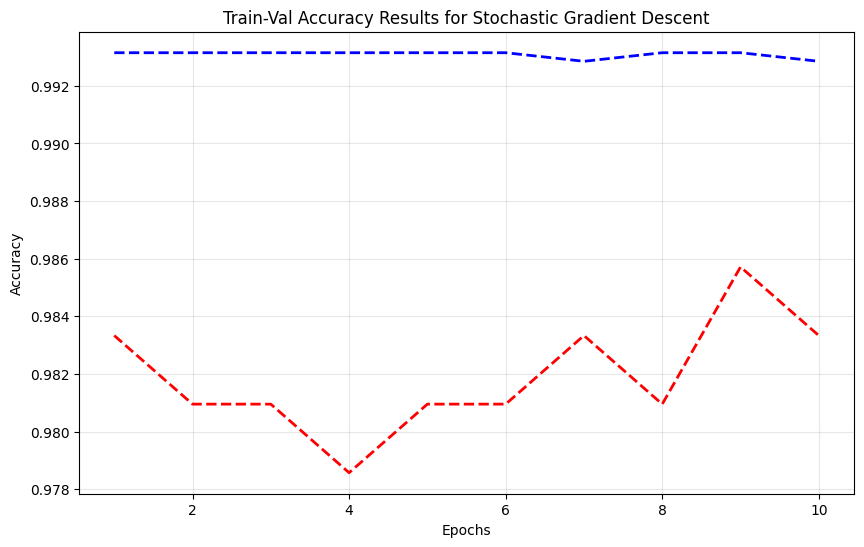

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.969047619047619, 'weighted_precision': 0.9699087571536552, 'wighted_recall': 0.969047619047619, 'weighted_f1': 0.9686953659362406, 'macro_precision': 0.9756235827664399, 'macro_recall': 0.954437595109747, 'macro_f1': 0.9640200064579475, 'roc_auc': 0.954437595109747}, 'confusion_matrix': array([[282,   1],
       [ 12, 125]], dtype=int64), 'epochs': 10}


Begin Perceptron
Perceptron begins epoch 5
Perceptron begins epoch 10
Perceptron classification report


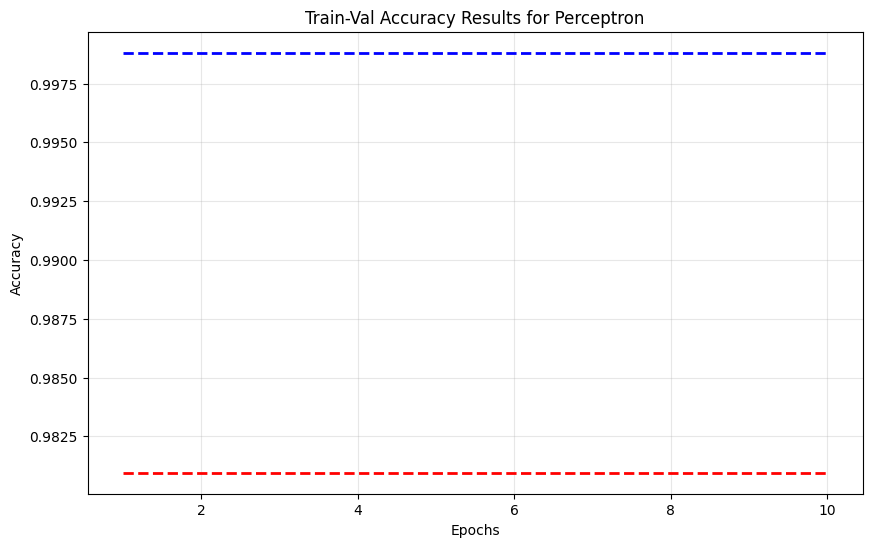

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9880952380952381, 'weighted_precision': 0.9880853749950684, 'wighted_recall': 0.9880952380952381, 'weighted_f1': 0.9880839325283769, 'macro_precision': 0.9873653686826844, 'macro_recall': 0.9855175259859172, 'macro_f1': 0.986433319766653, 'roc_auc': 0.9855175259859172}, 'confusion_matrix': array([[281,   2],
       [  3, 134]], dtype=int64), 'epochs': 10}


Begin PassiveAggressiveClassifier
Passive-Aggressive begins epoch 5
Passive-Aggressive begins epoch 10
PassiveAggressiveClassifier classification report


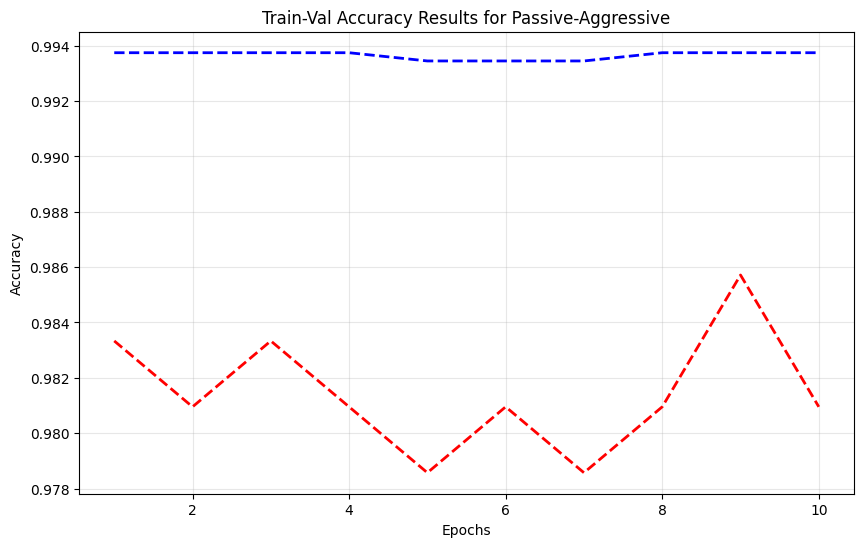

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9766319218488961, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9759983582650004, 'macro_precision': 0.9806601134819788, 'macro_recall': 0.965386500219236, 'macro_f1': 0.9724922061250687, 'roc_auc': 0.965386500219236}, 'confusion_matrix': array([[282,   1],
       [  9, 128]], dtype=int64), 'epochs': 10}


Begin MLPClassifier
SVM begins epoch 10
K-nearest Neighbors begins epoch 5
SVC classification report


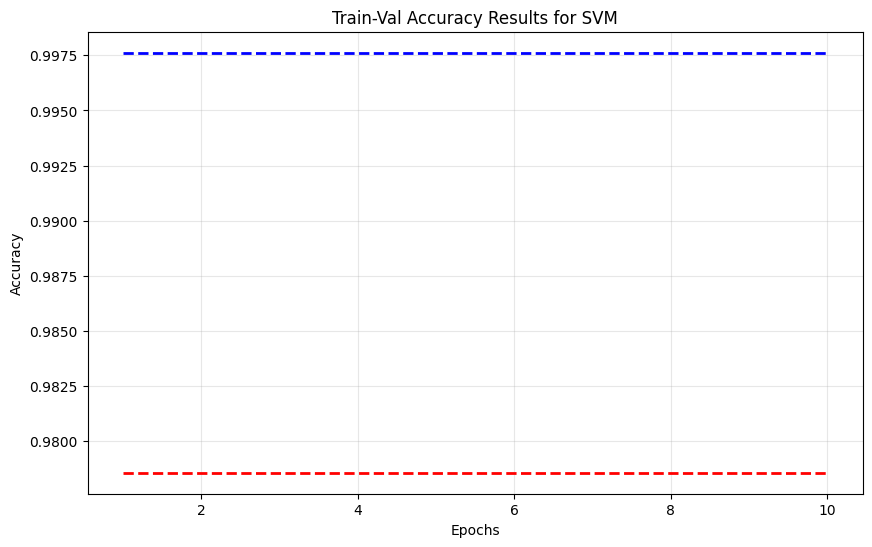

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9761904761904762, 'weighted_precision': 0.9770030879245897, 'wighted_recall': 0.9761904761904762, 'weighted_f1': 0.9759462181337183, 'macro_precision': 0.9829351535836177, 'macro_recall': 0.9635036496350364, 'macro_f1': 0.9723800505050506, 'roc_auc': 0.9635036496350364}, 'confusion_matrix': array([[283,   0],
       [ 10, 127]], dtype=int64), 'epochs': 10}


K-nearest Neighbors begins epoch 10
Multi-layer Perceptron begins epoch 5
KNeighborsClassifier classification report


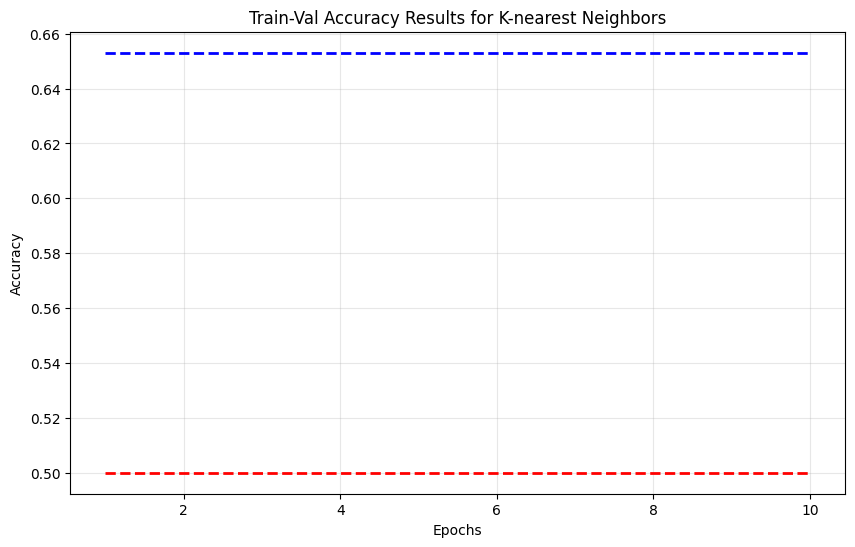

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.5142857142857142, 'weighted_precision': 0.8048596564725597, 'wighted_recall': 0.5142857142857142, 'weighted_f1': 0.4810731375469349, 'macro_precision': 0.7008797653958945, 'macro_recall': 0.6395759717314488, 'macro_f1': 0.5048429228599829, 'roc_auc': 0.6395759717314488}, 'confusion_matrix': array([[ 79, 204],
       [  0, 137]], dtype=int64), 'epochs': 10}


Multi-layer Perceptron begins epoch 10
MLPClassifier classification report


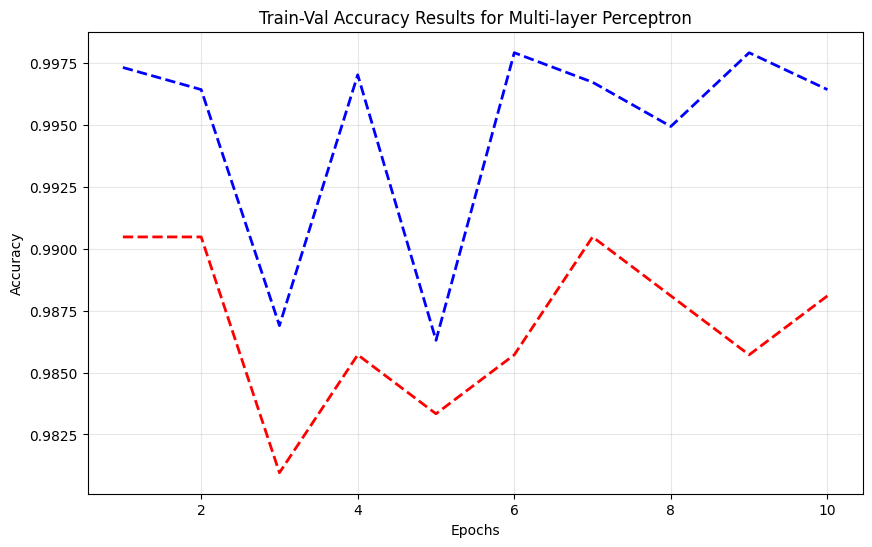

{'dataset': 'spam_assassin_lemmatized_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9833333333333333, 'weighted_precision': 0.9833515986501062, 'wighted_recall': 0.9833333333333333, 'weighted_f1': 0.9832850191419313, 'macro_precision': 0.983796054691577, 'macro_recall': 0.9782182559129247, 'macro_f1': 0.9809337284936998, 'roc_auc': 0.9782182559129247}, 'confusion_matrix': array([[281,   2],
       [  5, 132]], dtype=int64), 'epochs': 10}




In [25]:
train_and_evaluate_models(
    spam_assassin_lemmatizing_tfidf, 
    csv_file["Is_spam"], 
    "spam_assassin_lemmatized_tfidf",
    metric_results,
    mode="epochs",
    test_size=0.1,
    valid_size=0.1)

del spam_assassin_lemmatizing_tfidf

In [26]:
print(metric_results)

def convert(dic):
    dic["confusion_matrix"] = dic["confusion_matrix"].tolist()
    return dic

metric_results = list(map(convert, metric_results))

add_to_json_array("./spam_assassin_classification_report.json", metric_results, mode="overwrite")

[{'dataset': 'spam_assassin_stemming_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9404761904761905, 'weighted_precision': 0.9419603174603175, 'wighted_recall': 0.9404761904761905, 'weighted_f1': 0.9393753470179577, 'macro_precision': 0.9483333333333334, 'macro_recall': 0.9162905264243894, 'macro_f1': 0.9299210443766643, 'roc_auc': 0.9162905264243892}, 'confusion_matrix': array([[279,   4],
       [ 21, 116]], dtype=int64), 'epochs': 10}, {'dataset': 'spam_assassin_stemming_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9571428571428572, 'weighted_precision': 0.9572555018970748, 'wighted_recall': 0.9571428571428572, 'weighted_f1': 0.9567970448770009, 'macro_precision': 0.9582833852793096, 'macro_recall': 0.9437208222640634, 'macro_f1': 0.9504859710251239, 'roc_auc': 0.9437208222640634}, 'confusion_matrix': array([[278,   5],
       [ 13, 124]], dtype=int64), 'epochs': 10}, {'dataset': 'spam_assassin_